In [1]:
import os

def list_folders_and_files(root_folder):
    for root, dirs, files in os.walk(root_folder):
        print(f"📂 Folder: {root}")
        for file in files:
            print(f"   └── {file}")


folder_path = "/kaggle/input/pcamv1/pcamv1"  # replace with your folder
list_folders_and_files(folder_path)


📂 Folder: /kaggle/input/pcamv1/pcamv1
   └── camelyonpatch_level_2_split_train_y.h5
   └── camelyonpatch_level_2_split_valid_y.h5
   └── camelyonpatch_level_2_split_valid_meta.csv
   └── camelyonpatch_level_2_split_valid_x.h5
   └── camelyonpatch_level_2_split_train_mask.h5
   └── camelyonpatch_level_2_split_train_meta.csv
   └── camelyonpatch_level_2_split_test_y.h5
   └── camelyonpatch_level_2_split_test_meta.csv
   └── camelyonpatch_level_2_split_test_x.h5
📂 Folder: /kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_train_x.h5-001
   └── camelyonpatch_level_2_split_train_x.h5


Available keys in train_x: ['x']
Available keys in train_y: ['y']
Available keys in train_mask: ['mask']
Label: [[[1]]]


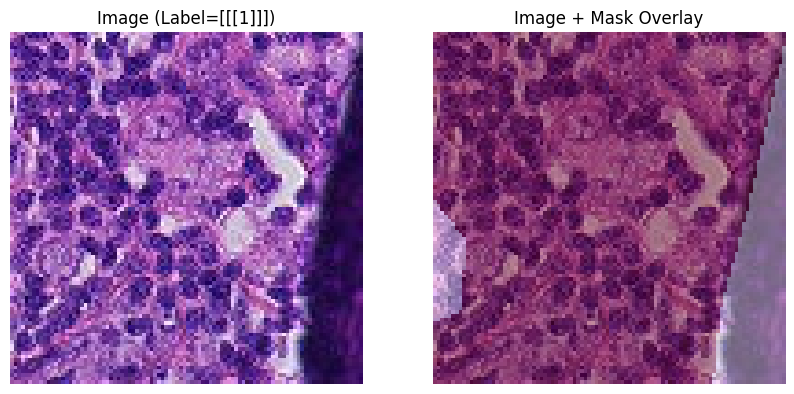

In [2]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

# File paths (adjust if needed)
train_x_path = "/kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_train_x.h5-001/camelyonpatch_level_2_split_train_x.h5"
train_y_path = "/kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_train_y.h5"
train_mask_path = "/kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_train_mask.h5"

# Open datasets
with h5py.File(train_x_path, "r") as x_file, \
     h5py.File(train_y_path, "r") as y_file, \
     h5py.File(train_mask_path, "r") as mask_file:

    # Explore dataset keys
    print("Available keys in train_x:", list(x_file.keys()))
    print("Available keys in train_y:", list(y_file.keys()))
    print("Available keys in train_mask:", list(mask_file.keys()))

    # Get data arrays
    X = x_file["x"]        # shape: (N, 96, 96, 3)
    Y = y_file["y"]        # shape: (N,)
    M = mask_file["mask"]  # shape: (N, 96, 96)

    # Pick an index to visualize
    idx = 100  

    image = X[idx]
    label = Y[idx]
    mask = M[idx]

    print(f"Label: {label}")

    # Show image with mask overlay
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image (Label={label})")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.imshow(mask, cmap="Reds", alpha=0.4)  # overlay mask
    plt.title("Image + Mask Overlay")
    plt.axis("off")

    plt.show()


# Step 1. Load the Dataset

Input files:

*_x.h5 → image patches (96x96x3)

*_y.h5 → binary labels (0 = normal, 1 = tumor)

*_mask.h5 → optional masks (can be used for visualization or segmentation tasks, but for classification we just use labels).

Split into train / validation / test sets (the dataset already provides these).

In [3]:
import h5py
import numpy as np

# Paths to dataset files
train_x_path = "/kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_train_x.h5-001/camelyonpatch_level_2_split_train_x.h5"
train_y_path = "/kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_train_y.h5"

valid_x_path = "/kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_valid_x.h5"
valid_y_path = "/kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_valid_y.h5"

test_x_path = "/kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_test_x.h5"
test_y_path = "/kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_test_y.h5"

def load_h5_data(x_path, y_path):
    """Load images and labels from .h5 files"""
    with h5py.File(x_path, "r") as x_file, h5py.File(y_path, "r") as y_file:
        X = np.array(x_file["x"])  # shape: (N, 96, 96, 3)
        y = np.array(y_file["y"])  # shape: (N,)
    return X, y

# Load datasets
X_train, y_train = load_h5_data(train_x_path, train_y_path)
X_valid, y_valid = load_h5_data(valid_x_path, valid_y_path)
X_test, y_test = load_h5_data(test_x_path, test_y_path)

# Print dataset shapes
print("Train:", X_train.shape, y_train.shape)
print("Valid:", X_valid.shape, y_valid.shape)
print("Test :", X_test.shape, y_test.shape)


Train: (262144, 96, 96, 3) (262144, 1, 1, 1)
Valid: (32768, 96, 96, 3) (32768, 1, 1, 1)
Test : (32768, 96, 96, 3) (32768, 1, 1, 1)


# Step 2. Preprocess the Data

Convert images from HDF5 (X) into NumPy arrays or PyTorch Dataset objects.

Normalize pixel values (e.g., [0, 255] → [0, 1] or use ImageNet normalization if fine-tuning ResNet).

Optionally apply data augmentation:

Random horizontal/vertical flips

Random rotations

Color jitter

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# 1. Define transforms
# ResNet expects normalized images (ImageNet mean & std)
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 2. Create custom Dataset
class PCamDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
    
        # ensure correct dtype
        image = image.astype('uint8')  
    
        if self.transform:
            image = self.transform(image)
    
        # Convert label to scalar long tensor
        label = int(label)  # <--- this is the fix
        return image, torch.tensor(label, dtype=torch.long)


# 3. Create Dataset objects
train_dataset = PCamDataset(X_train, y_train, transform=train_transform)
valid_dataset = PCamDataset(X_valid, y_valid, transform=valid_transform)
test_dataset  = PCamDataset(X_test, y_test, transform=valid_transform)

# 4. Wrap in DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False, num_workers=2)

print("Datasets ready ✅")
print(f"Train batches: {len(train_loader)}, Valid batches: {len(valid_loader)}")


Datasets ready ✅
Train batches: 4096, Valid batches: 512


# Step 3. Define the Model (ResNet)

Import a pretrained ResNet (e.g., ResNet18/34/50) from PyTorch or TensorFlow.

Modify the final fully-connected (FC) layer to output 2 classes (tumor / normal).

Decide whether to:

Fine-tune all layers (slower, more accurate with large dataset).

Freeze backbone and only train the last layer (faster, needs less data).

In [5]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Get input features of last layer
in_features = model.fc.in_features

# Replace last layer with 2-class classifier
model.fc = nn.Linear(in_features, 2)

# Send model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Step 4. Choose Loss Function and Optimizer

Loss: Binary Cross-Entropy (or BCEWithLogitsLoss in PyTorch).

Optimizer: Adam or SGD with momentum.

Learning rate: Start with 1e-4 to 1e-3.

Optionally use a learning rate scheduler.

In [6]:
import torch.optim as optim

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam for now, you can try SGD with momentum later)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Learning rate scheduler (optional, reduces LR on plateau)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                 factor=0.1, patience=3,
                                                 verbose=True)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# Step 5. Training Loop Validation

Run on validation set after each epoch.

Save the best model based on validation performance.

In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, device, num_epochs=10):
    best_auc = 0.0
    history = {"train_loss": [], "valid_loss": [], "train_acc": [], "valid_acc": [],
               "precision": [], "recall": [], "specificity": [], "f1": [], "roc_auc": []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        # ---------------- Training ----------------
        model.train()
        running_loss, running_corrects, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()
            total += labels.size(0)

        epoch_train_loss = running_loss / total
        epoch_train_acc = running_corrects / total

        # ---------------- Validation ----------------
        model.eval()
        val_loss, val_corrects, val_total = 0.0, 0, 0
        all_labels = []
        all_preds = []
        all_probs = []

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                probs = torch.softmax(outputs, dim=1)[:, 1]  # probability of class 1

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data).item()
                val_total += labels.size(0)

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())

        epoch_val_loss = val_loss / val_total
        epoch_val_acc = val_corrects / val_total
        precision = precision_score(all_labels, all_preds)
        recall = recall_score(all_labels, all_preds)  # sensitivity
        f1 = f1_score(all_labels, all_preds)
        tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
        specificity = tn / (tn + fp)
        roc_auc = roc_auc_score(all_labels, all_probs)

        # ---------------- Scheduler Step ----------------
        if scheduler:
            scheduler.step(epoch_val_loss)

        # Save metrics
        history["train_loss"].append(epoch_train_loss)
        history["valid_loss"].append(epoch_val_loss)
        history["train_acc"].append(epoch_train_acc)
        history["valid_acc"].append(epoch_val_acc)
        history["precision"].append(precision)
        history["recall"].append(recall)
        history["specificity"].append(specificity)
        history["f1"].append(f1)
        history["roc_auc"].append(roc_auc)

        # Print metrics
        print(f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f}")
        print(f"Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}")
        print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | Specificity: {specificity:.4f} | F1: {f1:.4f} | ROC-AUC: {roc_auc:.4f}")

        # Save best model based on ROC-AUC
        if roc_auc > best_auc:
            best_auc = roc_auc
            torch.save(model.state_dict(), "best_resnet_model.pth")
            print("✅ Best model saved based on ROC-AUC!")

    return history


history = train_model(
    model, 
    train_loader, 
    valid_loader, 
    criterion, 
    optimizer, 
    scheduler, 
    device, 
    num_epochs=5  # or 10 if you want
)



Epoch 1/5
--------------------


/tmp/ipykernel_256/3418952808.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label)  # <--- this is the fix
/tmp/ipykernel_256/3418952808.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label)  # <--- this is the fix
/tmp/ipykernel_256/3418952808.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label)  # <--- this is the fix
/tmp/ipykernel_256/3418952808.py:44: DeprecationWarning: Conversion of an array with ndim >

Train Loss: 0.1925 | Train Acc: 0.9250
Val Loss: 0.2957 | Val Acc: 0.8905
Precision: 0.9463 | Recall: 0.8277 | Specificity: 0.9531 | F1: 0.8830 | ROC-AUC: 0.9607
✅ Best model saved based on ROC-AUC!

Epoch 2/5
--------------------


/tmp/ipykernel_256/3418952808.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label)  # <--- this is the fix
/tmp/ipykernel_256/3418952808.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label)  # <--- this is the fix
/tmp/ipykernel_256/3418952808.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label)  # <--- this is the fix
/tmp/ipykernel_256/3418952808.py:44: DeprecationWarning: Conversion of an array with ndim >

Train Loss: 0.1281 | Train Acc: 0.9531
Val Loss: 0.4721 | Val Acc: 0.8384
Precision: 0.9553 | Recall: 0.7097 | Specificity: 0.9669 | F1: 0.8144 | ROC-AUC: 0.9371

Epoch 3/5
--------------------


/tmp/ipykernel_256/3418952808.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label)  # <--- this is the fix
/tmp/ipykernel_256/3418952808.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label)  # <--- this is the fix
/tmp/ipykernel_256/3418952808.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label)  # <--- this is the fix
/tmp/ipykernel_256/3418952808.py:44: DeprecationWarning: Conversion of an array with ndim >

Train Loss: 0.1074 | Train Acc: 0.9614
Val Loss: 0.3809 | Val Acc: 0.8685
Precision: 0.9570 | Recall: 0.7715 | Specificity: 0.9654 | F1: 0.8543 | ROC-AUC: 0.9512

Epoch 4/5
--------------------


/tmp/ipykernel_256/3418952808.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label)  # <--- this is the fix
/tmp/ipykernel_256/3418952808.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label)  # <--- this is the fix
/tmp/ipykernel_256/3418952808.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label)  # <--- this is the fix
/tmp/ipykernel_256/3418952808.py:44: DeprecationWarning: Conversion of an array with ndim >

Train Loss: 0.0941 | Train Acc: 0.9667
Val Loss: 0.4664 | Val Acc: 0.8520
Precision: 0.9681 | Recall: 0.7277 | Specificity: 0.9760 | F1: 0.8308 | ROC-AUC: 0.9434

Epoch 5/5
--------------------


/tmp/ipykernel_256/3418952808.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label)  # <--- this is the fix
/tmp/ipykernel_256/3418952808.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label)  # <--- this is the fix
/tmp/ipykernel_256/3418952808.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label)  # <--- this is the fix
/tmp/ipykernel_256/3418952808.py:44: DeprecationWarning: Conversion of an array with ndim >

Train Loss: 0.0849 | Train Acc: 0.9700
Val Loss: 0.4897 | Val Acc: 0.8355
Precision: 0.9519 | Recall: 0.7063 | Specificity: 0.9644 | F1: 0.8109 | ROC-AUC: 0.9390


# Step 6. Visualization & Interpretability 

Show example predictions with masks to see if the model focuses on tumor regions.

Use Grad-CAM or attention maps to visualize model reasoning.

/tmp/ipykernel_256/3418952808.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label)  # <--- this is the fix
/tmp/ipykernel_256/4046202085.py:40: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


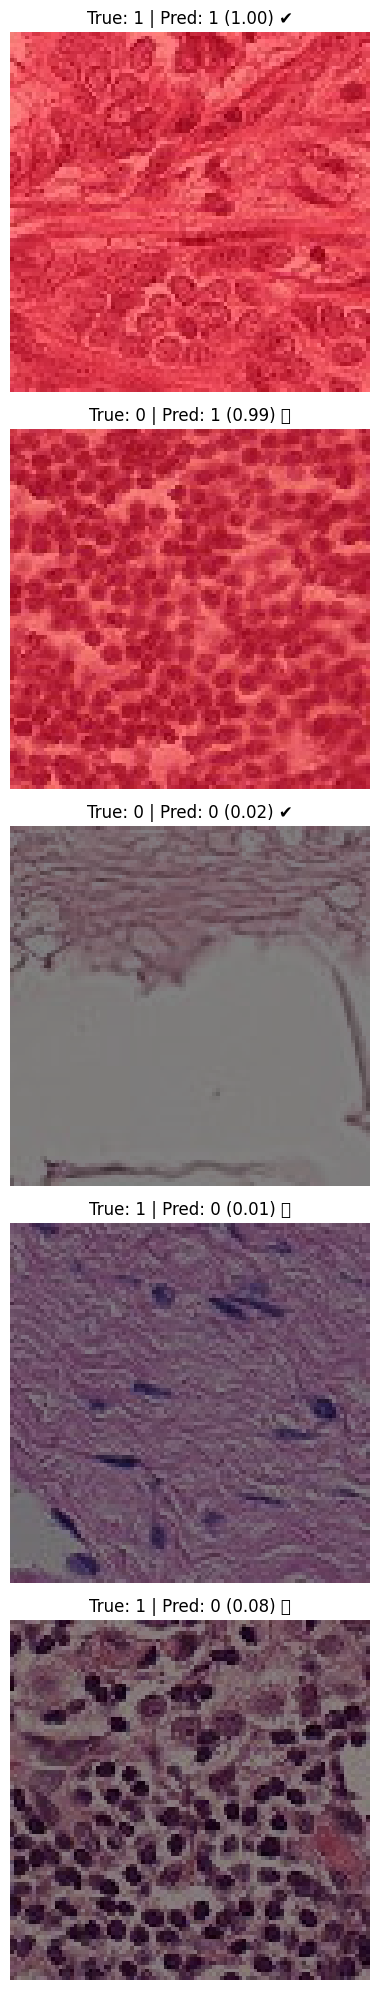

In [10]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

def visualize_predictions(model, dataset, device, num_samples=5):
    model.eval()
    indices = torch.randint(0, len(dataset), (num_samples,))
    
    plt.figure(figsize=(12, 4 * num_samples))
    
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        image_input = image.unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(image_input)
            probs = F.softmax(outputs, dim=1)
            pred_label = torch.argmax(probs, dim=1).item()
            pred_prob = probs[0, 1].item()  # probability of class 1 (tumor)

        # Convert image tensor to numpy
        img_np = image.permute(1, 2, 0).cpu().numpy()
        img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img_np = np.clip(img_np, 0, 1)

        # Create overlay mask from predicted probability
        mask_overlay = np.ones((img_np.shape[0], img_np.shape[1], 3))
        mask_overlay[..., 0] = pred_prob  # red channel proportional to probability
        mask_overlay[..., 1] = 0          # green
        mask_overlay[..., 2] = 0          # blue

        plt.subplot(num_samples, 1, i+1)
        plt.imshow(img_np)
        plt.imshow(mask_overlay, alpha=0.5)  # semi-transparent red overlay

        correct = "✔️" if pred_label == label else "❌"
        plt.title(f"True: {label} | Pred: {pred_label} ({pred_prob:.2f}) {correct}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Usage
visualize_predictions(model, valid_dataset, device, num_samples=5)


# Step 7. Generating a Report

In [13]:
import pandas as pd

def save_training_report(history, filename="training_report.csv"):
    """
    Save all training and validation metrics to a CSV file.
    
    history: dict returned by the training loop
    filename: output CSV file name
    """
    # Convert history dict to DataFrame
    df = pd.DataFrame({
        "train_loss": history["train_loss"],
        "valid_loss": history["valid_loss"],
        "train_acc": history["train_acc"],
        "valid_acc": history["valid_acc"],
        "precision": history["precision"],
        "recall": history["recall"],
        "specificity": history["specificity"],
        "f1_score": history["f1"],
        "roc_auc": history["roc_auc"]
    })

    # Save to CSV
    df.to_csv(filename, index_label="epoch")
    print(f"✅ Training report saved to '{filename}'")

# Example usage
save_training_report(history, filename="pcam_resnet18_experiment.csv")


✅ Training report saved to 'pcam_resnet18_experiment.csv'
